### Import data set from Kaggle

In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/hsankesara/flickr-image-dataset/code")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jakobbruchhausen
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.16G/8.16G [05:16<00:00, 27.7MB/s]


### Import dependancies

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import shutil
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch import nn
import matplotlib.pyplot as plt
import torch
from itertools import chain
from PIL import Image

### Data loading and handling

In [4]:
all_img_path = Path.cwd() / "flickr-image-dataset/flickr30k_images"
all_img_filenames = list(all_img_path.glob("*.jpg"))
train_filenames, testval_filenames = train_test_split(all_img_filenames, test_size=0.2, random_state=1)
val_filenames, test_filenames = train_test_split(testval_filenames, test_size=0.5, random_state=1)

subdirectories = {"train": train_filenames,
                  "val": val_filenames,
                  "test": test_filenames,
                 }

for subdirectory in subdirectories.keys():
    subdirectory = Path(subdirectory)
    subdirectory.mkdir(parents=True, exist_ok=True)
    
def fill_sub_dir(sub_dir, file_subset):
    
    for file in file_subset:
        file_path = Path.cwd() / sub_dir / file.name
        shutil.copyfile(file, file_path)
        
for sub_dir, file_subset in subdirectories.items():
    fill_sub_dir(sub_dir, file_subset)

In [5]:
class ImgData(Dataset):
    
    def __init__(self, root, transform_grayscale, transform_color):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
        
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.root = root
        self.transform_grayscale = transform_grayscale
        self.transform_color = transform_color
        
        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_imgs_sub_dir(self.root)
            
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path = self._samples[index]
        # Load the image into memory
        gray_img = Image.open(path)
        c_img = Image.open(path)
        
        # Perform transforms, if any.
        if self.transform_grayscale is not None:
            gray_img = self.transform_grayscale(gray_img)
            
        if self.transform_color is not None:
            c_img = self.transform_color(c_img)
        return gray_img, c_img
    
    def __len__(self):
        """Total number of samples"""
        return len(self._samples)
    
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return list(sub_dir.glob("*.jpg"))
    
example_dataset = ImgData("./train", transform_grayscale=transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                                                             transforms.ToTensor()]), 
                          transform_color=transforms.ToTensor())

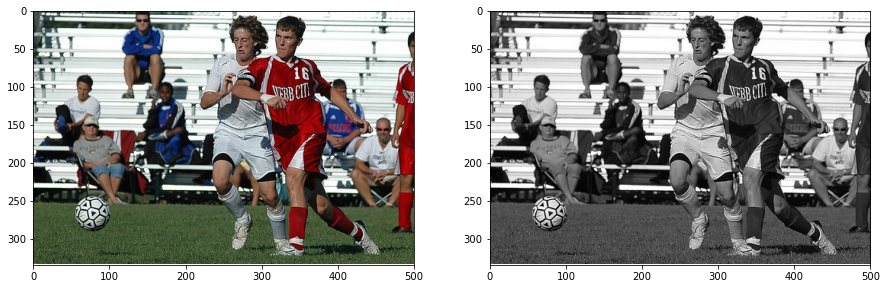

In [6]:
def display_image(axis1, axis2, image_tensor1, image_tensor2):
    """Display a tensor as an image
    
    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """
    
    # See hint above
    if not isinstance(image_tensor1, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")
        
    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data1 = image_tensor1.permute(1, 2, 0).detach().numpy()
    image_data2 = image_tensor2.permute(1, 2, 0).detach().numpy()
    height1, width1, _ = image_data1.shape
    height2, width2, _ = image_data2.shape
    axis1.imshow(image_data1)
    axis2.imshow(image_data2)

    axis1.set_xlim(0, width1)
    axis2.set_xlim(0, width2)
    axis1.set_ylim(height1, 0)
    axis2.set_ylim(height2, 0)


# Example usage
_, (axis1, axis2) = plt.subplots(1,2, figsize=(15,15))
some_random_index = np.random.randint(25000)
# Here we use the __getitem__ method as a "magic" method.
# Implementing it for a class, enables square bracket '[]' indexing
gray_image, color_image = example_dataset[some_random_index]
display_image(axis1, axis2, color_image, gray_image)
#print(gray_image)
#print(color_image)

### Data pre-processing

In [25]:
# create greyscale data loaders for training, validataion and test data
img_size = 32
batch_size = 128

transform_grayscale = transforms.Compose([transforms.Resize((img_size,img_size)) , 
                                transforms.Grayscale(num_output_channels=3), 
                                transforms.ToTensor()])
transform_color = transforms.Compose([transforms.Resize((img_size,img_size)), 
                                transforms.ToTensor()])

train_dataloader = DataLoader(ImgData("./train", transform_grayscale=transform_grayscale,
                                     transform_color=transform_color),
                                   batch_size=batch_size,
                                   shuffle=True,
                                     num_workers=0)
val_dataloader = DataLoader(ImgData("./val", transform_grayscale=transform_grayscale,
                                     transform_color=transform_color),
                                   batch_size=batch_size,
                                   shuffle=True,
                                     num_workers=0)
test_dataloader = DataLoader(ImgData("./test", transform_grayscale=transform_grayscale,
                                     transform_color=transform_color),
                                   batch_size=batch_size,
                                   shuffle=True,
                                     num_workers=0)


### Creating the model

torch.Size([128, 3, 32, 32]) torch.Size([128, 3, 32, 32])
1


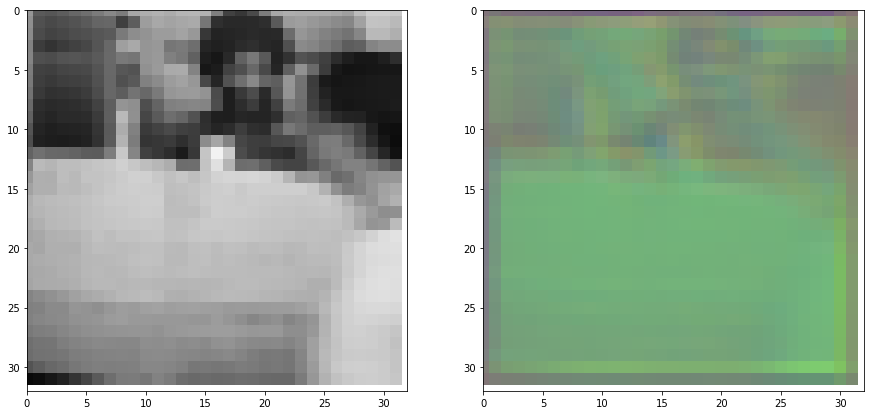

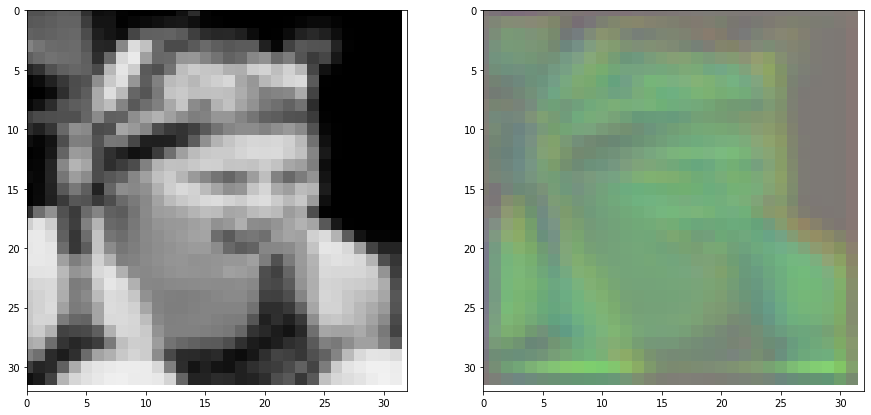

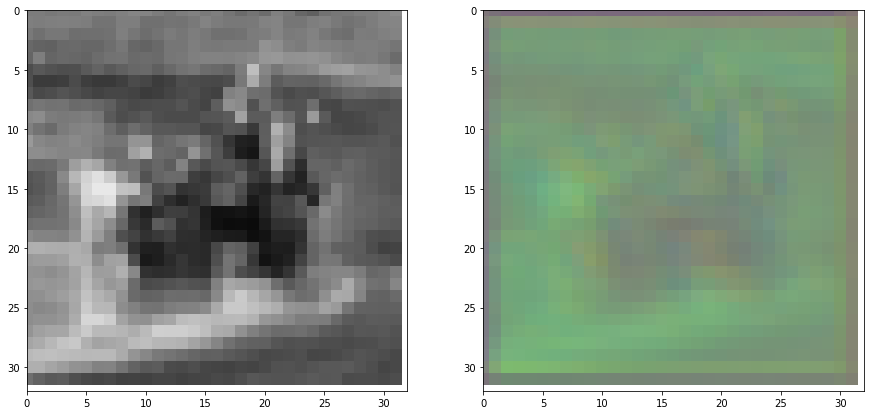

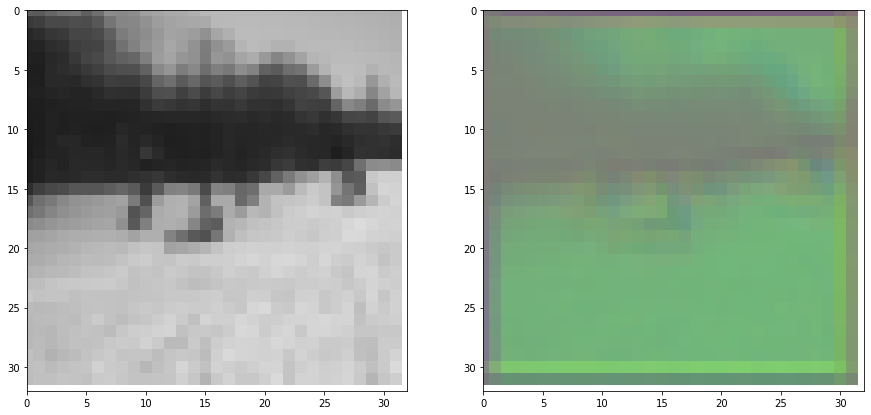

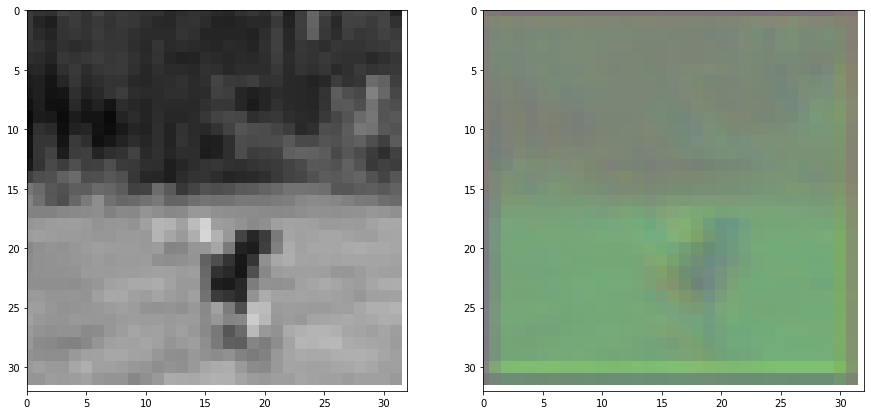

In [26]:
class ColorizationNetwork(nn.Module):
    def __init__(self):
        super(ColorizationNetwork, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 10, 3, stride=1, padding=0),
            #nn.Conv2d(10, 10, 3, stride=1, padding=0),
            nn.ConvTranspose2d(10,3,3, stride=1, padding=0)
        )
                
    def forward(self, input_batch):
        logits = self.conv_stack(input_batch)
        return torch.sigmoid(logits)

test_network = ColorizationNetwork()


for batch, (x,y) in enumerate(train_dataloader, 1):
    print(x.shape,y.shape)
    print(batch)
    log = test_network.forward(x)
    for i in range(5):
        _, (axis1, axis2) = plt.subplots(1,2, figsize=(15,15))
        display_image(axis1, axis2, x[i], log[i])
    break

#print(log)


### Defining training loop

In [31]:
def training(model, optimizer, loss_fn, batch_size, train_loader, val_loader, num_epocs, val_freq):
    print("---- Starting training ----")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    
    train_loss_list, val_loss_list = [], []
    train_t, val_t = [], []
    
    # training over epochs
    for epoch in range(num_epochs):
        print(f"Epoch = {epoch+1}")
        model.train()
        num_batches = len(train_loader)
        train_loss_batch = []
        
        #val_loss = validate(model, loss_fn, val_loader, device)
        #val_loss_list.append(val_loss)
        #val_t.append(epoch)
        
        # iterating over all batches and training samples
        for batch, (x, y) in enumerate(train_loader, 1):
            print(batch)
            X, trueImg = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model.forward(X)
            loss = loss_fn(output, trueImg)
            loss.backward()
            optimizer.step()
            
            train_loss_list.append(loss.item())
            train_t.append(batch / batch_size + epoch)
            del X
                
            if val_freq is not None and batch % print_freq == 0:
                val_loss = validate(model, loss_fn, val_loader, device)
                model.train()
                val_loss_list.append(val_loss)
                val_t.append(batch / batch_size + epoch)
                
                print(f"Epoch {epoch+1}/{num_epochs+1}: \n"
                      f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
                      f"Val. loss: {val_loss:.3f}")
                
                
        print(f"Epoch {epoch+1}/{num_epochs+1}: \n"
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Val. loss: {val_loss:.3f}")  
                          
    return model, train_loss_list, val_loss_list, train_t, val_t

        
def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(val_loader, 1):
            X, trueImg = x.to(device), y.to(device)
            output = model.forward(X)
            
            batch_loss = loss_fn(output, trueImg)
            val_loss_cum += batch_loss.item()
            val_loss_cum /= len(val_loader)
            
    return val_loss_cum
    

In [32]:
net = ColorizationNetwork()

learning_rate = .01
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
num_epochs = 1

model, train_loss_list, val_loss_list, train_t, val_t = training(net,
                                                                 optimizer, 
                                                                 loss_fn, 
                                                                 batch_size, 
                                                                 train_dataloader, val_dataloader, 
                                                                 num_epochs, val_freq=None)

---- Starting training ----
cpu
Epoch = 1
1
2
3
4


KeyboardInterrupt: 